## Model Inference
학습된 Model을 이용하여 실제 사진에 대한 Inference를 수행합니다.

### Model Loading

In [1]:
import torch
import torch.nn as nn
from torchvision import models

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
def build_model(num_classes):
    model = models.convnext_tiny(weights="IMAGENET1K_V1")

    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)

    return model

In [3]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
DEVICE

device(type='cuda')

In [4]:
NUM_CLASSES = 9
pth_path = "final_convnext_tiny_acc_93.86.pth"

model = build_model(NUM_CLASSES)

checkpoint = torch.load(pth_path, map_location=DEVICE)

model.to(DEVICE)

if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
elif 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint
model.load_state_dict(state_dict)
        
model.eval()

print("Model Loaded")

Model Loaded


### Inference

In [5]:
import ipywidgets as widgets
from IPython.display import display
from torchvision import transforms
from PIL import Image
import io

RESIZE_VALUE = 256
INPUT_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
CLASS_NAMES = ['건전지', '비닐', '스티로품', '유리병', '종이', '철캔', '페트병', '플라스틱', '형광등']

In [6]:
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

예측 클래스: 스티로품, 확률: 61.98%


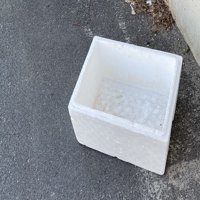

In [8]:
inference_transforms = transforms.Compose([
    transforms.Resize(RESIZE_VALUE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

if uploader.value:
    uploaded_file = uploader.value[0] if isinstance(uploader.value, tuple) else list(uploader.value.values())[0]
    content = uploaded_file['content']

    image = Image.open(io.BytesIO(content)).convert('RGB')

    transformed_image = inference_transforms(image)

    input_batch = transformed_image.unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(input_batch)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        top_prob, top_class = torch.topk(probs, 1)

    print(f"예측 클래스: {CLASS_NAMES[top_class.item()]}, 확률: {top_prob.item()*100:.2f}%")
    display(image.resize((200, 200)))
else:
    print('Image upload error')